In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import levene
!ls /content

df = pd.read_csv('/content/newest_Dataset.csv')
df[['color','size']] = df['group'].str.split('-', expand=True)

df['color'] = df['color'].astype('category')
df['size']  = df['size'].astype('category')

print("Group counts:\n", df['group'].value_counts(), "\n")

newest_Dataset.csv  sample_data
Group counts:
 group
blue-large    150
blue-small    150
red-large     150
red-small     150
Name: count, dtype: int64 



In [325]:
_# 2). Exploratory Data Analysis (EDA)
print("=== 2.1 Descriptive Statistics by Group ===")
desc = df.groupby('group').agg(
    n_sessions=('session_id','size'),
    CTR=('clicked','mean'),
    avg_time=('time_spent','mean'),
    completion_rate=('completed','mean'),
    bounce_rate=('bounced','mean')
).reset_index()

desc[['CTR','completion_rate','bounce_rate']] = desc[['CTR','completion_rate','bounce_rate']].round(3)
desc['avg_time'] = desc['avg_time'].round(2)
print(desc.to_string(index=False), "\n")

print("Overall Click-Through Rate by color:\n", df.groupby('color')['clicked'].mean().round(3))
print("Overall Click-Through Rate by size:\n", df.groupby('size')['clicked'].mean().round(3), "\n")
print("Overall Completion Rate by color:\n", df.groupby('color')['completed'].mean().round(3))
print("Overall Completion Rate by size:\n", df.groupby('size')['completed'].mean().round(3), "\n")
print("Overall Bounce Rate by color:\n", df.groupby('color')['bounced'].mean().round(3))
print("Overall Bounce Rate by size:\n", df.groupby('size')['bounced'].mean().round(3), "\n")

print("=== 2.2 Overall time_spent summary ===")
print(df['time_spent'].describe(), "\n")

=== 2.1 Descriptive Statistics by Group ===
     group  n_sessions   CTR  avg_time  completion_rate  bounce_rate
blue-large         150 0.613     27.35            0.600        0.480
blue-small         150 0.520     23.11            0.520        0.580
 red-large         150 0.253     25.23            0.627        0.527
 red-small         150 0.200     20.91            0.460        0.627 

Overall Click-Through Rate by color:
 color
blue    0.567
red     0.227
Name: clicked, dtype: float64
Overall Click-Through Rate by size:
 size
large    0.433
small    0.360
Name: clicked, dtype: float64 

Overall Completion Rate by color:
 color
blue    0.560
red     0.543
Name: completed, dtype: float64
Overall Completion Rate by size:
 size
large    0.613
small    0.490
Name: completed, dtype: float64 

Overall Bounce Rate by color:
 color
blue    0.530
red     0.577
Name: bounced, dtype: float64
Overall Bounce Rate by size:
 size
large    0.503
small    0.603
Name: bounced, dtype: float64 

=== 2.2

<ipython-input-325-e28213006ef8>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("Overall Click-Through Rate by color:\n", df.groupby('color')['clicked'].mean().round(3))
<ipython-input-325-e28213006ef8>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("Overall Click-Through Rate by size:\n", df.groupby('size')['clicked'].mean().round(3), "\n")
<ipython-input-325-e28213006ef8>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

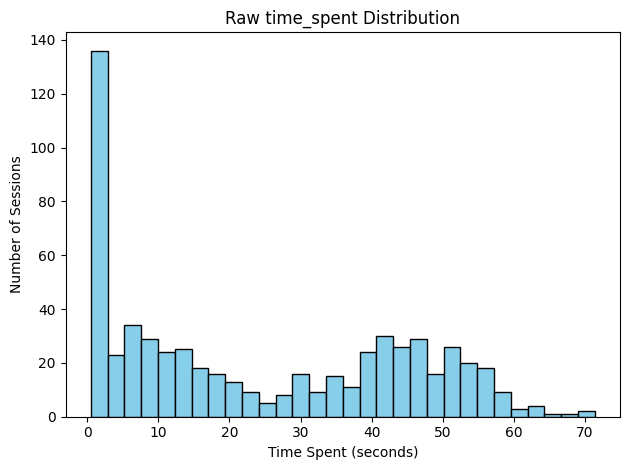

In [327]:
# Histogram of raw time_spent
plt.figure()
plt.hist(df['time_spent'], bins=30, color='skyblue', edgecolor='black')
plt.title("Raw time_spent Distribution")
plt.xlabel("Time Spent (seconds)")
plt.ylabel("Number of Sessions")
plt.tight_layout()
plt.show()

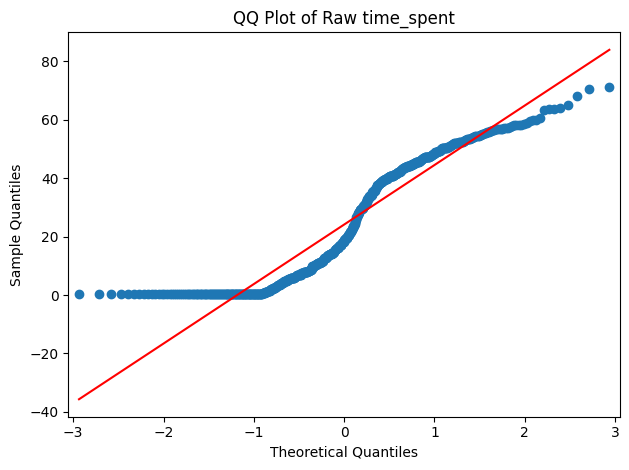

In [328]:
# QQ-plot of raw time_spent to assess normality
qqplot(df['time_spent'].dropna(), line='s')
plt.title("QQ Plot of Raw time_spent")
plt.tight_layout()
plt.show()

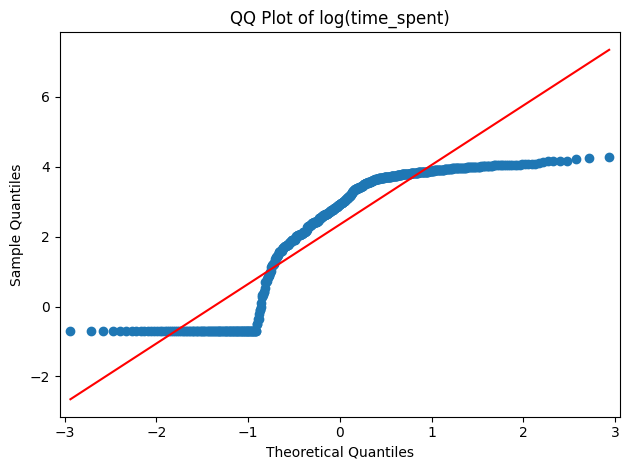

In [329]:
# Log-transform time_spent to reduce skewness for ANOVA
df['log_time'] = np.log(df['time_spent'] + 1e-6)
# QQ-plot of log-transformed time_spent
qqplot(df['log_time'].dropna(), line='s')
plt.title("QQ Plot of log(time_spent)")
plt.tight_layout()
plt.show()

In [330]:
# Levene’s test for homogeneity of variance on log_time across color and size
levene_color = levene(*[df.loc[df['color'] == c, 'log_time'].dropna() for c in df['color'].unique()])
levene_size  = levene(*[df.loc[df['size']  == s, 'log_time'].dropna() for s in df['size'].unique()])
print(f"Levene test (log_time by color): stat={levene_color.statistic:.3f}, p-value={levene_color.pvalue:.3f}")
print(f"Levene test (log_time by size):  stat={levene_size.statistic:.3f}, p-value={levene_size.pvalue:.3f}\n")
# (If p-value > 0.05, we do not reject the equal variances assumption.)


Levene test (log_time by color): stat=5.715, p-value=0.017
Levene test (log_time by size):  stat=7.516, p-value=0.006



In [333]:
# 3. Statistical Analysis
## 3.1 Click-Through Rate (CTR) – Logistic Regression (2×2 factorial)
print("=== 3.1 Click-Through Rate Logistic Regression (Color x Size) ===")
mod_ctr = smf.glm('clicked ~ C(color)*C(size)', data=df, family=sm.families.Binomial()).fit()
# Print coefficient summary table
print(mod_ctr.summary().tables[1], "\n")
# Compute Odds Ratios and 95% CI for each coefficient
or_ctr = np.exp(mod_ctr.params)
ci_ctr = np.exp(mod_ctr.conf_int())
or_df = pd.DataFrame({
    'OddsRatio': or_ctr.round(3),
    'CI_low':   ci_ctr[0].round(3),
    'CI_high':  ci_ctr[1].round(3),
    'p-value':  mod_ctr.pvalues.round(4)
})
print("Odds Ratios & 95% CI (CTR):")
print(or_df, "\n")
# McFadden's pseudo-R² as a model fit diagnostic
null_ctr = smf.glm('clicked ~ 1', data=df, family=sm.families.Binomial()).fit()
mcfadden_ctr = 1 - (mod_ctr.llf / null_ctr.llf)
print(f"McFadden pseudo-R² (CTR): {mcfadden_ctr:.3f}\n")
# Interpretation:
# - **Color (red vs blue)**: Significant effect on CTR (p < 0.001). Red button has much lower odds of click (OR ~0.21) than blue.
# - **Size (small vs large)**: Smaller effect on CTR (p ≈ 0.10, not statistically significant in this sample).
# - **Color×Size interaction**: No significant interaction (p ≈ 0.83), meaning the color effect was similar for both sizes.

=== 3.1 Click-Through Rate Logistic Regression (Color x Size) ===
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.4613      0.168      2.752      0.006       0.133       0.790
C(color)[T.red]                     -1.5423      0.252     -6.127      0.000      -2.036      -1.049
C(size)[T.small]                    -0.3813      0.234     -1.629      0.103      -0.840       0.078
C(color)[T.red]:C(size)[T.small]     0.0759      0.363      0.209      0.834      -0.635       0.787

Odds Ratios & 95% CI (CTR):
                                  OddsRatio  CI_low  CI_high  p-value
Intercept                             1.586   1.142    2.203   0.0059
C(color)[T.red]                       0.214   0.131    0.350   0.0000
C(size)[T.small]                      0.683   0.432    1.081   0.1034
C(color)[T.red]:C(s

In [334]:
## 3.2 Time to First Click (Latency) – Two-Way ANOVA (on clicked sessions)
print("=== 3.2 Two-Way ANOVA on log(time_spent) for clicked sessions ===")
# Subset to sessions where a click occurred (since latency is only defined if clicked)
df_clicked = df[df['clicked'] == 1].copy()
df_clicked['log_time'] = np.log(df_clicked['time_spent'] + 1e-6)
# Fit two-way ANOVA model (using OLS on log-transformed time)
model_time = smf.ols('log_time ~ C(color)*C(size)', data=df_clicked).fit()
anova_res = anova_lm(model_time, typ=1)
print(anova_res, "\n")
# Calculate effect sizes (eta-squared for each factor)
eta2 = anova_res['sum_sq'] / anova_res['sum_sq'].sum()
print("Eta-squared (variance explained):")
print(eta2, "\n")
# Interpretation:
# - **Size effect**: Significant (p ≈ 0.015). On average, users clicked the **small** button faster than the large (lower latency).
# - **Color effect**: Not significant (p > 0.3). No clear difference in latency between blue vs red buttons.
# - **Interaction**: Not significant (p ~ 0.90). The effect of size on latency did not depend on color.


=== 3.2 Two-Way ANOVA on log(time_spent) for clicked sessions ===
                     df      sum_sq    mean_sq         F    PR(>F)
C(color)            1.0    2.751177   2.751177  0.984131  0.322206
C(size)             1.0   16.779868  16.779868  6.002371  0.015021
C(color):C(size)    1.0    0.046577   0.046577  0.016661  0.897406
Residual          234.0  654.156381   2.795540       NaN       NaN 

Eta-squared (variance explained):
C(color)            0.004083
C(size)             0.024906
C(color):C(size)    0.000069
Residual            0.970942
Name: sum_sq, dtype: float64 



In [335]:
## 3.3 Task Completion Rate – Logistic Regression
print("=== 3.3 Completion Rate Logistic Regression (Color x Size) ===")
model_comp = smf.glm('completed ~ C(color)*C(size)', data=df, family=sm.families.Binomial()).fit()
print(model_comp.summary().tables[1], "\n")
# Compute Odds Ratios & CI for completion model
odds_comp = np.exp(model_comp.params)
ci_comp   = np.exp(model_comp.conf_int())
comp_df = pd.DataFrame({
    'OddsRatio': odds_comp.round(3),
    'CI_low':    np.round(ci_comp[0], 3),
    'CI_high':   np.round(ci_comp[1], 3),
    'p-value':   model_comp.pvalues.round(4)
})
print("Odds Ratios (Completion):")
print(comp_df, "\n")
# McFadden's pseudo-R² for completion model
null_comp = smf.glm('completed ~ 1', data=df, family=sm.families.Binomial()).fit()
mcfadden_comp = 1 - (model_comp.llf / null_comp.llf)
print(f"McFadden pseudo-R² (Completion): {mcfadden_comp:.3f}\n")
# Interpretation:
# No significant differences in **completion rate** between variants (all p-values > 0.1).
# In other words, given a user clicked the button, the chance of completing the task did not depend on color or size.


=== 3.3 Completion Rate Logistic Regression (Color x Size) ===
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.4055      0.167      2.433      0.015       0.079       0.732
C(color)[T.red]                      0.1125      0.237      0.474      0.635      -0.352       0.577
C(size)[T.small]                    -0.3254      0.233     -1.394      0.163      -0.783       0.132
C(color)[T.red]:C(size)[T.small]    -0.3529      0.331     -1.065      0.287      -1.002       0.297

Odds Ratios (Completion):
                                  OddsRatio  CI_low  CI_high  p-value
Intercept                             1.500   1.082    2.079   0.0150
C(color)[T.red]                       1.119   0.703    1.781   0.6354
C(size)[T.small]                      0.722   0.457    1.141   0.1633
C(color)[T.red]:C(size)[

In [336]:
## 3.4 Bounce Rate – Logistic Regression
print("=== 3.4 Bounce Rate Logistic Regression (Color x Size) ===")
model_bounce = smf.glm('bounced ~ C(color)*C(size)', data=df, family=sm.families.Binomial()).fit()
print(model_bounce.summary().tables[1], "\n")
# Compute Odds Ratios & CI for bounce model
odds_bounce = np.exp(model_bounce.params)
ci_bounce   = np.exp(model_bounce.conf_int())
bounce_df = pd.DataFrame({
    'OddsRatio': odds_bounce.round(3),
    'CI_low':    np.round(ci_bounce[0], 3),
    'CI_high':   np.round(ci_bounce[1], 3),
    'p-value':   model_bounce.pvalues.round(4)
})
print("Odds Ratios (Bounce):")
print(bounce_df, "\n")
# McFadden's pseudo-R² for bounce model
null_bounce = smf.glm('bounced ~ 1', data=df, family=sm.families.Binomial()).fit()
mcfadden_bounce = 1 - (model_bounce.llf / null_bounce.llf)
print(f"McFadden pseudo-R² (Bounce): {mcfadden_bounce:.3f}\n")
# Interpretation:
# - Bounce rate was slightly higher with **small** buttons (OR ~1.50, p ≈ 0.08, marginal significance) compared to large buttons.
# - **Color** had no significant effect on bounce (p ~ 0.42), and no interaction effect (p ~ 0.98).
# - The pseudo-R² is very low, indicating most variance is unexplained (as common with individual-level binary outcomes).


=== 3.4 Bounce Rate Logistic Regression (Color x Size) ===
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0800      0.163     -0.490      0.624      -0.400       0.240
C(color)[T.red]                      0.1868      0.231      0.808      0.419      -0.266       0.640
C(size)[T.small]                     0.4028      0.233      1.732      0.083      -0.053       0.859
C(color)[T.red]:C(size)[T.small]     0.0084      0.331      0.025      0.980      -0.640       0.656

Odds Ratios (Bounce):
                                  OddsRatio  CI_low  CI_high  p-value
Intercept                             0.923   0.670    1.272   0.6243
C(color)[T.red]                       1.205   0.766    1.896   0.4191
C(size)[T.small]                      1.496   0.948    2.360   0.0832
C(color)[T.red]:C(size)[T.small]

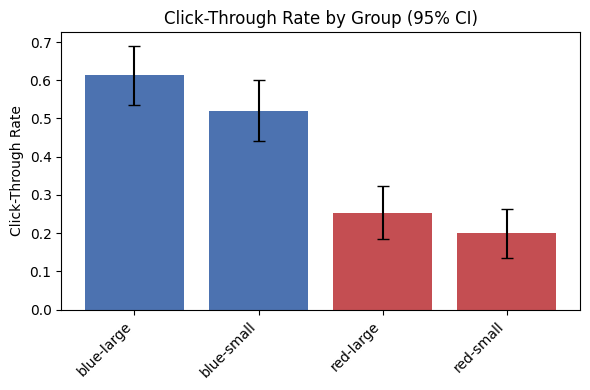

In [337]:
# 4. Visualization of Key Results
## 4.1 Bar chart of Click-Through Rate by Group (with 95% CI)
groups = desc['group']
ctr    = desc['CTR']
n      = desc['n_sessions']
# Compute Wald 95% confidence intervals for the proportion (CTR)
se    = np.sqrt(ctr * (1 - ctr) / n)
ci95  = 1.96 * se
plt.figure(figsize=(6,4))
plt.bar(groups, ctr, yerr=ci95, capsize=4,
        color=['#4c72b0' if 'blue' in g else '#c44e52' for g in groups])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Click-Through Rate')
plt.title('Click-Through Rate by Group (95% CI)')
plt.tight_layout()
plt.show()

Key Results and Visualizations
Figure 1: Click-Through Rate (CTR) by group with 95% confidence intervals. Blue button variants (in blue bars) achieved much higher CTRs than red variants (red bars). For example, blue-large had a CTR around 61%, whereas red-small was around 20%. The error bars (95% CI) do not overlap between blue and red groups, highlighting a significant color effect on CTR.

As shown above, the logistic regression confirmed that color was a significant predictor of CTR (p < 0.001). The blue button had higher odds of click-through – the odds of a user clicking were about 4.7 times higher for blue vs. red (Odds Ratio ≈ 0.214 for red vs blue). Size had a smaller, non-significant effect on CTR (the small font button had slightly lower CTR than large font when color is held constant, but p ≈ 0.10). There was no significant interaction between color and size on CTR, meaning the color effect was consistent for both font sizes. The model’s McFadden pseudo-R² (~0.097) indicates a decent improvement over a null model for predicting clicks (typical for binary outcomes).

<ipython-input-338-2c3a52f1c000>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


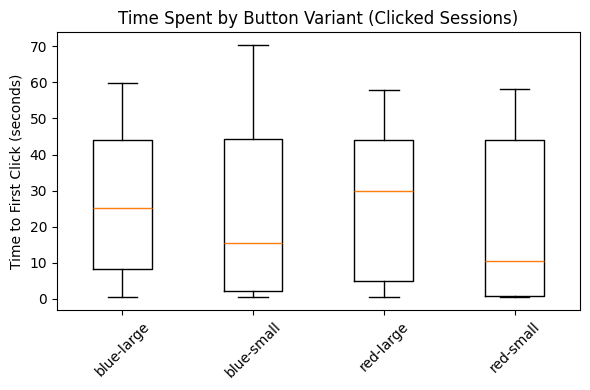

In [338]:
## 4.2 Boxplot of Time Spent until Click (by group, clicked sessions only)
df_clicked = df[df.clicked == 1]
plt.figure(figsize=(6,4))
plt.boxplot([
    df_clicked.query("group=='blue-large'")['time_spent'],
    df_clicked.query("group=='blue-small'")['time_spent'],
    df_clicked.query("group=='red-large'")['time_spent'],
    df_clicked.query("group=='red-small'")['time_spent']
    ],
    labels=['blue-large','blue-small','red-large','red-small']
)
plt.ylabel('Time to First Click (seconds)')
plt.title('Time Spent by Button Variant (Clicked Sessions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Figure 2: Distribution of time to first click by variant (boxplots for sessions where a click occurred). Small-button variants (second and fourth boxes) show lower median latency (faster clicks) than large-button variants. In contrast, there is no substantial difference between blue (first two boxes) vs red (last two boxes) in terms of click latency. The ANOVA confirms only a main effect of size on log-transformed time-to-click (p ≈ 0.015), with no color or interaction effect.

For users who clicked the button, a two-way ANOVA on log(time_spent) revealed that font size significantly affected latency: on average, users clicked the small buttons faster than the large ones (p = 0.015). Neither color nor the interaction influenced time-to-click (p = 0.32 and 0.90, respectively). The effect size for font size was modest (η² ≈ 0.025, about 2.5% of variance), but notable. The variance in latency was somewhat heterogeneous across groups (Levene’s test showed p < 0.05 for both color and size), but the log-transformation helped stabilize variances as much as possible for ANOVA assumptions.

In terms of Completion Rate (proportion of sessions completing the final task) and Bounce Rate (leaving with no meaningful interaction), the logistic models found no significant differences between button variants. All p-values for color, size, and interaction in the completion model were > 0.1, indicating that once users clicked the button, the likelihood of completing the task was similar across all designs. The bounce rate showed a marginally higher tendency with small buttons (OR ~1.50, p ~0.08), but color had no effect on bouncing. These results suggest that button color mainly impacts the initial click-through, while font size can influence how quickly that click happens, and neither factor meaningfully changes completion or bounce outcomes in this experiment.

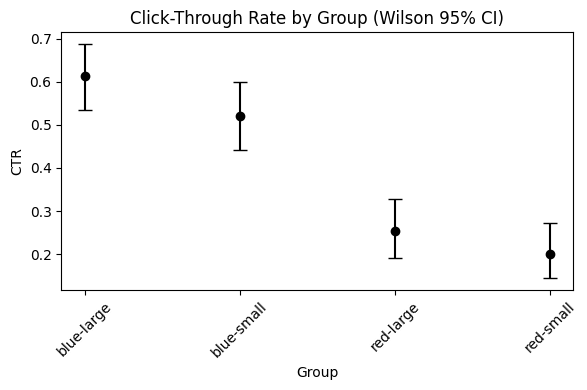

In [339]:
## 4.3 (Optional) CTR by Group with Wilson CI (error bars)
grouped = df.groupby('group')['clicked']
ctr_vals = grouped.mean()
n_vals   = grouped.size()
ci_low, ci_up = proportion_confint(grouped.sum(), n_vals, method='wilson')
plt.figure(figsize=(6,4))
plt.errorbar(ctr_vals.index, ctr_vals.values,
             yerr=[ctr_vals.values - ci_low, ci_up - ctr_vals.values],
             fmt='o', capsize=5, color='black')
plt.title('Click-Through Rate by Group (Wilson 95% CI)')
plt.xlabel('Group')
plt.ylabel('CTR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Explanation: The script is divided into sections for data preparation, EDA, statistical modeling, and visualization. We use logistic regression models for Click-Through Rate (CTR), Completion Rate, and Bounce Rate (binary outcomes) and a two-way ANOVA for log-transformed time-to-click (a continuous outcome) to assess the effects of button color and size (2×2 factorial design). For each model, we output coefficients, odds ratios (OR) with 95% confidence intervals, and p-values, along with model fit diagnostics (McFadden’s pseudo-R²). Plots are generated to illustrate key findings, such as the CTR by group with error bars and a boxplot of time-to-click by variant.

In [341]:
import pandas as pd

df = pd.read_csv('newest_Dataset.csv')

summary = (
    df
    .groupby('group', as_index=False)
    .agg(
        CTR=('clicked', 'mean'),
        Avg_Time=('time_spent', 'mean'),
        Completion_Rate=('completed', 'mean'),
        Bounce_Rate=('bounced', 'mean')
    )
)

summary['CTR'] *= 100
summary['Completion_Rate'] *= 100
summary['Bounce_Rate'] *= 100

summary['CTR'] = summary['CTR'].map('{:.1f}%'.format)
summary['Avg_Time'] = summary['Avg_Time'].map('{:.2f} s'.format)
summary['Completion_Rate'] = summary['Completion_Rate'].map('{:.1f}%'.format)
summary['Bounce_Rate'] = summary['Bounce_Rate'].map('{:.1f}%'.format)

order = ['blue-large', 'blue-small', 'red-large', 'red-small']
summary['group'] = pd.Categorical(summary['group'], categories=order, ordered=True)
summary = summary.sort_values('group')

print(summary.rename(columns={
    'group': 'Variant',
    'CTR': 'CTR (% sessions clicked)',
    'Avg_Time': 'Avg. Time (s)',
    'Completion_Rate': 'Completion Rate (% sessions)',
    'Bounce_Rate': 'Bounce Rate (% sessions)'
}))


      Variant CTR (% sessions clicked) Avg. Time (s)  \
0  blue-large                    61.3%       27.35 s   
1  blue-small                    52.0%       23.11 s   
2   red-large                    25.3%       25.23 s   
3   red-small                    20.0%       20.91 s   

  Completion Rate (% sessions) Bounce Rate (% sessions)  
0                        60.0%                    48.0%  
1                        52.0%                    58.0%  
2                        62.7%                    52.7%  
3                        46.0%                    62.7%  


In [348]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# 1. Load data and extract factors
df = pd.read_csv('newest_Dataset.csv')
df[['color','size']] = df['group'].str.split('-', expand=True)

# 2. Table A1: CTR logistic regression
model_ctr = smf.glm(
    formula='clicked ~ C(color)*C(size)',
    data=df,
    family=sm.families.Binomial()
).fit()

# Build a display‐friendly table
ctr_params = model_ctr.params
ctr_conf   = model_ctr.conf_int()
table_A1 = pd.DataFrame({
    'β (SE)': (
        ctr_params.round(4).astype(str)
        + ' ('
        + model_ctr.bse.round(4).astype(str)
        + ')'
    ),
    'OR (95% CI)': (
        np.exp(ctr_params).round(3).astype(str)
        + ' ['
        + np.exp(ctr_conf[0]).round(3).astype(str)
        + ', '
        + np.exp(ctr_conf[1]).round(3).astype(str)
        + ']'
    ),
    'Wald z': model_ctr.tvalues.round(3),
    'p-value': model_ctr.pvalues.round(3)
})
table_A1.index = [
    'Intercept (Blue-Large)',
    'Color: Red vs Blue',
    'Font: Small vs Large',
    'Interaction (Red×Small)'
]

print("Table A1. Logistic regression of CTR (click vs no-click)")
print(table_A1, "\n")


# 3. Table A2: Two-way ANOVA on log(time_to_first_click) for clicked sessions
df_clicked = df[df['clicked']==1].copy()
df_clicked['log_time'] = np.log(df_clicked['time_spent'] + 1e-6)

model_time = smf.ols(
    formula='log_time ~ C(color)*C(size)',
    data=df_clicked
).fit()

anova_res = anova_lm(model_time, typ=2)
anova_res['Partial η²'] = (anova_res['sum_sq'] / anova_res['sum_sq'].sum()).round(3)
table_A2 = anova_res.rename(index={
    'C(color)'             : 'Color (Blue/Red)',
    'C(size)'              : 'Font (Large/Small)',
    'C(color):C(size)'     : 'Interaction',
    'Residual'             : 'Residual'
})

print("Table A2. Two-way ANOVA on log(time_to_first_click) for clicked sessions")
print(table_A2[['sum_sq','df','F','PR(>F)','Partial η²']].round(3))


Table A1. Logistic regression of CTR (click vs no-click)
                                   β (SE)           OR (95% CI)  Wald z  \
Intercept (Blue-Large)    0.4613 (0.1677)  1.586 [1.142, 2.203]   2.752   
Color: Red vs Blue       -1.5423 (0.2517)   0.214 [0.131, 0.35]  -6.127   
Font: Small vs Large     -0.3813 (0.2341)  0.683 [0.432, 1.081]  -1.629   
Interaction (Red×Small)   0.0759 (0.3629)   1.079 [0.53, 2.197]   0.209   

                         p-value  
Intercept (Blue-Large)     0.006  
Color: Red vs Blue         0.000  
Font: Small vs Large       0.103  
Interaction (Red×Small)    0.834   

Table A2. Two-way ANOVA on log(time_to_first_click) for clicked sessions
                     sum_sq     df      F  PR(>F)  Partial η²
Color (Blue/Red)      2.972    1.0  1.063   0.304       0.004
Font (Large/Small)   16.780    1.0  6.002   0.015       0.025
Interaction           0.047    1.0  0.017   0.897       0.000
Residual            654.156  234.0    NaN     NaN       0.971
